In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import math
# from bmc import BMC
from sklearn.metrics import roc_auc_score
from tensorflow.image import ResizeMethod
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.models import Sequential,Model,load_model

In [ ]:
plt.rcParams.update({'font.size': 14})

X_train_file = "training_images.npy"
y_train_file = "training_labels.npy"

X_test_file = "test_images.npy"
y_test_file = "test_labels.npy"

def renormalize(array):
    return (array - array.min()) / (array.max() - array.min())

def cut_channels(X):
# "The SDSS uses the green wavelength picture for the blue band, the red wavelength picture for the green band 
# and the infrared wavelength picture for the red band."
    X = X[:, 1:-1, :, :] #BGR
    return X[:, ::-1, :, :] #RGB

def center_with_ref_to_imgnet(X):
    # source: https://github.com/keras-team/keras-applications/blob/06fbeb0f16e1304f239b2296578d1c50b15a983a/keras_applications/imagenet_utils.py#L18
    bgr_mean_vals = [103.939, 116.779, 123.68]

    mean = np.mean(bgr_mean_vals)
    X[..., 0:] -= mean
    return X

def preprocess_divided(X):
    u, gri, z = X[:, :, :, :1], X[:, :, :, 1:-1], X[:, :, :, -1:]
    
    gri = gri[:, :, :, ::-1]

    gri = tf.keras.applications.resnet50.preprocess_input(
      gri, data_format='channels_last'
    )

    u, z = center_with_ref_to_imgnet(u), center_with_ref_to_imgnet(z)
    return np.concatenate((u, gri, z), axis=-1)


def mean_weights(kernel):
    mean_vector = np.mean(kernel, axis=-2).reshape(kernel[:,:,-1:,:].shape)
    return(mean_vector)


# Loop through layers of both original model 
# and custom model and copy over weights 
# layer_modify refers to first convolutional layer
def copy_weights_tl(model_orig, custom_model, layer_modify):
  layer_to_modify = [layer_modify]

  conf = custom_model.get_config()
  layer_names = [conf['layers'][x]['name'] for x in range(len(conf['layers']))]

  for layer in model_orig.layers:
    if layer.name in layer_names:
      if layer.get_weights() != []:
        target_layer = custom_model.get_layer(layer.name)
        if layer.name in layer_to_modify:    
          kernel = layer.get_weights()[0]
          biases  = layer.get_weights()[1]

          mean_weights_vector = mean_weights(kernel)

          extended_kernel = np.concatenate((mean_weights_vector, kernel, mean_weights_vector),
                                                  axis=-2)
          print("kernel")
          print(kernel.shape)
          print("mean vector")
          print(mean_weights_vector.shape)
          print("extended kernel")
          print(extended_kernel.shape)
                                                  
          target_layer.set_weights([extended_kernel, biases])
          target_layer.trainable = False

        else:
          target_layer.set_weights(layer.get_weights())
          target_layer.trainable = False

  return custom_model


In [ ]:
X_train = np.load(X_train_file)
X_train = np.transpose(X_train, (0, 2, 3, 1))

y_train = np.load(y_train_file).astype('float32')
y_train = renormalize(y_train).astype(np.int32)

rng_state = np.random.get_state()
np.random.shuffle(X_train)
np.random.set_state(rng_state)
np.random.shuffle(y_train)

In [ ]:
first_for_validation = math.floor(len(X_train) * 0.8)

X_train_t = X_train[:first_for_validation]
X_train_v = X_train[first_for_validation:]

# X_train_t = tf.keras.applications.resnet50.preprocess_input(
#     X_train_t, data_format='channels_last'
# )

# X_train_v = tf.keras.applications.resnet50.preprocess_input(
#     X_train_v, data_format='channels_last'
# )

X_train_t = preprocess_divided(X_train_t)
X_train_v = preprocess_divided(X_train_v)

# X_train_t = tf.image.resize(X_train_t, (224, 224))
# X_train_v = tf.image.resize(X_train_v, (224, 224))

y_train_t = y_train[:first_for_validation]
y_train_v = y_train[first_for_validation:]

y_train_t = tf.one_hot(y_train_t, depth=2)
y_train_v = tf.one_hot(y_train_v, depth=2)

In [ ]:
img_height,img_width = 48,48
channels = 5
num_classes = 2

base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False)

# Get Resnet config in dictionary format
config = base_model.get_config()

# Change input shape to new dimensions
config["layers"][0]["config"]["batch_input_shape"] = (None, img_height, img_width, channels)

# Create new model with config
resnet50_5 = tf.keras.models.Model.from_config(config)
resnet50_5 = copy_weights_tl(base_model, resnet50_5, 'conv1_conv')

x = resnet50_5.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = resnet50_5.input, outputs = predictions)

adam = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

kernel
(7, 7, 3, 64)
mean vector
(7, 7, 1, 64)
extended kernel
(7, 7, 5, 64)


In [ ]:
history = model.fit(x=X_train_t, y=y_train_t, validation_data=(X_train_v, y_train_v), shuffle=True, epochs = 20, batch_size = 32)
model.save('./drive/MyDrive/model_48px_no_resizing/')

Epoch 1/20
92/92 [==============================] - 34s 375ms/step - loss: 0.5154 - auc_1: 0.8268 - val_loss: 0.4631 - val_auc_1: 0.8748
Epoch 2/20
92/92 [==============================] - 32s 347ms/step - loss: 0.5178 - auc_1: 0.8251 - val_loss: 0.4568 - val_auc_1: 0.8769
Epoch 3/20
92/92 [==============================] - 32s 349ms/step - loss: 0.5052 - auc_1: 0.8341 - val_loss: 0.4511 - val_auc_1: 0.8783
Epoch 4/20
92/92 [==============================] - 32s 348ms/step - loss: 0.5016 - auc_1: 0.8352 - val_loss: 0.4456 - val_auc_1: 0.8814
Epoch 5/20
92/92 [==============================] - 32s 347ms/step - loss: 0.4920 - auc_1: 0.8452 - val_loss: 0.4404 - val_auc_1: 0.8845
Epoch 6/20
92/92 [==============================] - 32s 348ms/step - loss: 0.4923 - auc_1: 0.8440 - val_loss: 0.4351 - val_auc_1: 0.8860
Epoch 7/20
92/92 [==============================] - 34s 373ms/step - loss: 0.4812 - auc_1: 0.8540 - val_loss: 0.4304 - val_auc_1: 0.8880
Epoch 8/20
92/92 [=======================

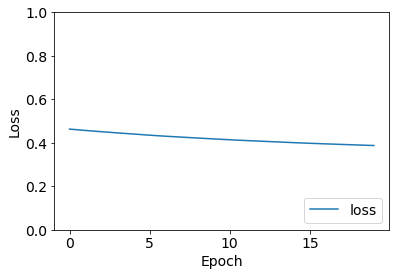

In [ ]:
plt.plot(history.history['val_loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(history.history.keys())

NameError: ignored

In [ ]:
X_test = np.load(X_test_file)
X_test = np.transpose(X_test, (0, 2, 3, 1))
X_test = preprocess_divided(X_test)
#X_test = tf.image.resize(X_test, (224, 224))

y_test = np.load(y_test_file).astype('float32')
y_test = renormalize(y_test).astype(np.int32)
y_test = tf.one_hot(y_test, depth=2)

In [ ]:
test_loss, test_auc = model.evaluate(X_test,  y_test, verbose=2)
print(test_auc)

pred = model.predict(X_test)
print(pred)

4/4 - 1s - loss: 0.4122 - auc_1: 0.8827 - 918ms/epoch - 229ms/step
0.8826999664306641
[[0.33659974 0.66340023]
 [0.72839797 0.27160203]
 [0.63270366 0.3672963 ]
 [0.12639755 0.8736025 ]
 [0.81432974 0.1856702 ]
 [0.8545465  0.14545345]
 [0.84028846 0.15971151]
 [0.80715746 0.19284254]
 [0.8547095  0.14529052]
 [0.8536574  0.14634262]
 [0.84786737 0.15213268]
 [0.81806684 0.18193313]
 [0.82596    0.17404003]
 [0.80774975 0.19225025]
 [0.8602569  0.13974307]
 [0.7667352  0.23326482]
 [0.8549428  0.14505723]
 [0.84747094 0.15252902]
 [0.85463285 0.14536712]
 [0.58158034 0.41841966]
 [0.7778866  0.22211333]
 [0.86228514 0.13771483]
 [0.7282818  0.27171823]
 [0.8599578  0.14004219]
 [0.24513902 0.75486094]
 [0.8409262  0.15907381]
 [0.8457805  0.15421955]
 [0.8316605  0.16833943]
 [0.8447747  0.15522525]
 [0.846237   0.15376298]
 [0.85483295 0.14516711]
 [0.17239569 0.8276043 ]
 [0.83132297 0.16867702]
 [0.27618933 0.7238107 ]
 [0.85007846 0.14992158]
 [0.8426243  0.15737575]
 [0.8596346  0